<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/master/code/1_gan_selection_20_steps_SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import time

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

In [15]:
from utils.tools import *

data = pd.read_table('./data/trips_SS_20_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

# colony = (-77.264, -11.773)
colony =  (-32.392, -3.819)
scale = 2e5

data = format_data(data, colony, scale)
data = data[data.dist_colony > 1000]

padding = 20
traj = padding_data(data, padding)

In [16]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        
        self.traj = traj   # save trips
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        sample = self.traj[idx,:]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [17]:
# hyperparameters
batch_size = 14

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [25]:
x =  next(iter(train_loader))

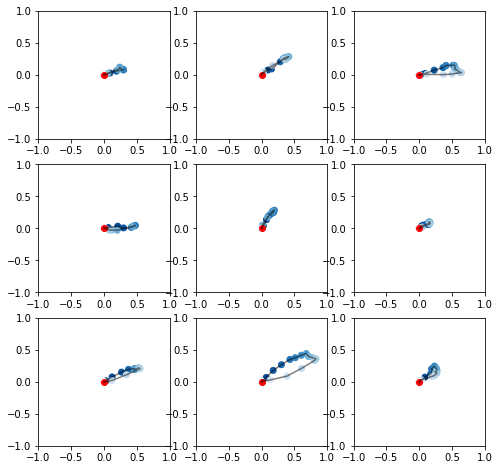

In [26]:
plt.figure(figsize = (8,8))
i = 4

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
    plt.xlim(-1,1)
    plt.ylim(-1,1)


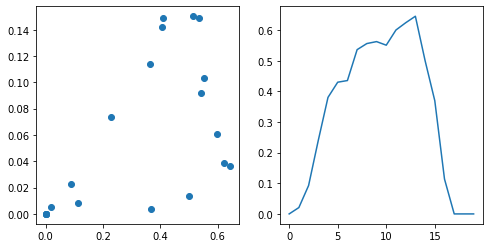

In [20]:
plt.figure(figsize = (8,4))

x = traj[0,0,:]
y = traj[0,1,:]

plt.subplot(1,2, 1)
plt.scatter(x, y)

plt.subplot(1,2, 2)
plt.plot(np.sqrt(x**2 + y**2))

## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [27]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## CNN

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(20, 10, kernel_size = 5, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(10),
            nn.ReLU(True),

            nn.ConvTranspose1d(10, 5, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(5),
            nn.ReLU(True),

            nn.ConvTranspose1d(5, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
        

    def forward(self, z, batch_size):    
        out = self.cnn(z)
        return out

In [30]:
gen = CNNGenerator().to(device)
z = torch.rand((batch_size, padding, 1)).to(device) # (batch, seq, feature)

out = gen(z, batch_size)
out.shape

torch.Size([14, 2, 20])

In [31]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            
            nn.Conv1d(2, 5, kernel_size = 5, stride = 1, padding = 2, bias = False),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(5, 10, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(10, 20, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(20),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(20, 1, kernel_size=5, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, batch_size):

        out = self.cnn(x)

        return out.squeeze(1)


In [32]:
dis = CNNDiscriminator().to(device)
dis(out, batch_size).shape

torch.Size([14, 1])

In [33]:
sum(p.numel() for p in gen.parameters())

1270

# LSTM

In [34]:
class LSTMGenerator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(1, 16, 1, batch_first=True, bias = True)
        self.linear = nn.Sequential(
                        nn.ReLU(),
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 2),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state

        # init LSTM cells  (batch, seq, feature)
        out, h_n = self.lstm(x, (h_0, c_0))
        out = self.linear(out)
        out = out.view(batch_size, 2, padding)
        return torch.cumsum(out, 2)

In [35]:
gen = LSTMGenerator().to(device)
z = torch.rand((batch_size, padding, 1)).to(device) # (batch, seq, feature)

out = gen(z, batch_size)
out.shape

torch.Size([14, 2, 20])

In [36]:
sum(p.numel() for p in gen.parameters())

1522

In [37]:
class LSTMDiscriminator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(2, 16, 1, batch_first=True)
        
        self.linear = nn.Sequential(
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 1),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #internal stat

        # init LSTM cells  (batch, seq, feature)
        out = x.view(batch_size, padding, 2)
        out, (h_n, c_n) = self.lstm(out, (h_0, c_0))
        out = self.linear(out)
        out = 1/(1 + torch.exp(-torch.mean(out, 1)))

        return out

In [38]:
dis = LSTMDiscriminator().to(device)
dis(out, batch_size).shape

torch.Size([14, 1])

In [39]:
class GAN :
  """
  This class creates a GAN with: 
   - a Generator network 
   - a Discriminator network
   - a Dataloader object from pytorch
  """
  def __init__(self, generator, discriminator, train_loader, device):
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)
    self.device = device
    self.train_loader = train_loader
    
  def train(self, nb_epoch, lr, device):
    """
    This function trains the GAN for nb_epoch with a fiwed learning rate lr
    """                                                       
    criterion = nn.BCELoss()
    optim_d = optim.Adam(discriminator.parameters(), lr= lr, betas=(0.5, 0.999))
    optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))
    score = []

    time_start = time.perf_counter()
    for epoch in range(nb_epoch):
        i = 0

        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for _, x in enumerate(self.train_loader):

            batch = x.shape[0]
            
            target_ones = torch.ones((batch, 1), device=self.device)
            target_zeros = torch.zeros((batch, 1), device=self.device)
            
            i+= 1
            #### TRAIN DISCRIMINATOR
            ## true samples
            x = x.to(device)

            self.discriminator.zero_grad()
            pred_real = self.discriminator(x, batch)
            loss_real = criterion(pred_real, target_ones)

            ## false samples
            seq_length =  x.shape[2]
            z = torch.rand((batch, seq_length, 1), device=self.device)
            with torch.no_grad():
                fake_samples = self.generator(z, batch)
            pred_fake = self.discriminator(fake_samples, batch)
            loss_fake = criterion(pred_fake, target_zeros)
            
            # combine
            loss = (loss_real + loss_fake) / 2
            loss.backward()
            optim_d.step()

            loss_d_real_running += loss_real.item()
            loss_d_fake_running += loss_fake.item()
            
            #### TRAIN GENERATOR
            self.generator.zero_grad()
            z = torch.rand((batch, seq_length, 1), device=self.device) 

            generated = self.generator(z, batch)
            classifications = self.discriminator(generated, batch)
            loss = criterion(classifications, target_ones) #+ 0.1 * torch.sum((generated[:,0, 0] - generated[:,0,-1])**2)
            loss.backward()
            optim_g.step()

            loss_g_running += loss.item()

        if epoch%100 == 0:
          traj_sim = self.test(100)
          score.append(get_score(traj, traj_sim))
       
        if epoch%500 == 0:
          print('Epoch [{}/{}] -----------------------------------------------------------------------------'
              .format(epoch+1, nb_epoch, i, len(self.train_loader)))
          print('G: {}, Dr : {}, Df : {}'
              .format(loss_g_running/batch, loss_d_real_running/batch, loss_d_fake_running/batch))
          
          self.plot()


    #run your code
    self.score = score
    self.computation_time = (time.perf_counter() - time_start)

  def test(self, nb):
    """
    This function generates nb trajectories
    """ 
    self.generator.zero_grad()    

    x =  next(iter(self.train_loader))
    seq_length = x.shape[2]

    z = torch.rand((nb, seq_length, 1), device=self.device)
    generated = self.generator(z, nb)
    traj_sim = generated.cpu().detach().numpy()
    return traj_sim

  def plot(self):
    """
    This function plots few trajectories
    """ 
    traj_sim = self.test(16)

    plt.figure(figsize = (8,8))
    for i in range(16):
      plt.subplot(4,4,i+1)
      plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
      plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
      plt.scatter(0,0, c = 'red')
      plt.xlim(-1,1)
      plt.ylim(-1,1)

    plt.show()
    plt.close()

  def save(self, name):
    torch.save(self.generator, name+'_G.pt')
    torch.save(self.discriminator, name+'_D.pt')

In [40]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# CNN - CNN

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.09432093586240496, Dr : 0.09958664434296745, Df : 0.10448821953364781


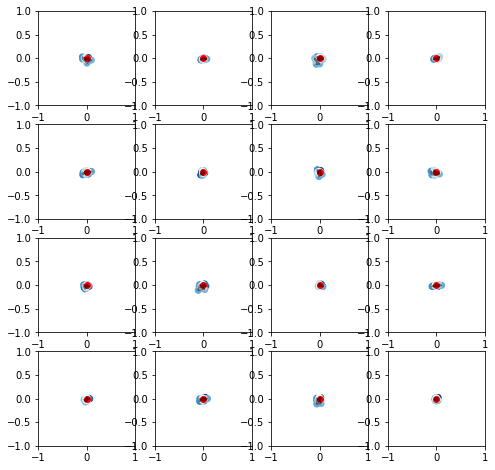

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.47450738293784006, Dr : 0.015067515362586294, Df : 0.0101789084396192


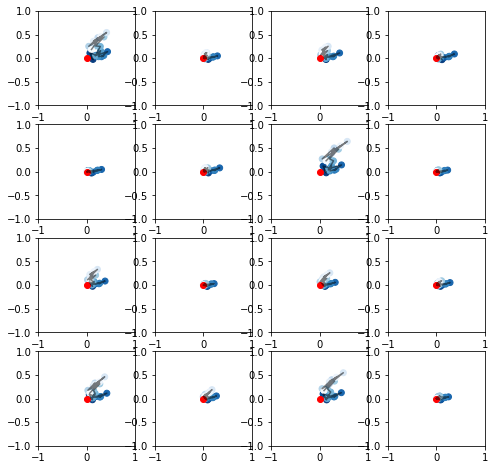

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.28538475717817036, Dr : 0.047471641429833004, Df : 0.030053279229572842


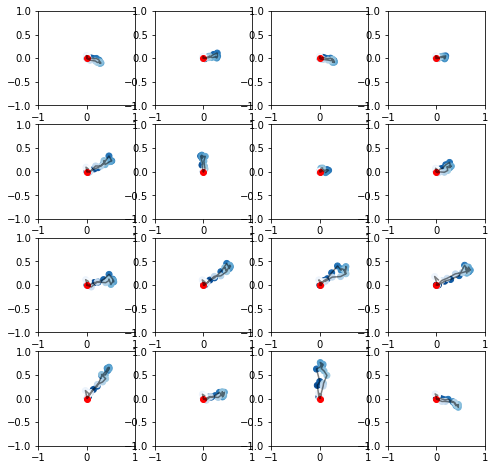

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.2629378182547433, Dr : 0.020679869822093418, Df : 0.025555638330323354


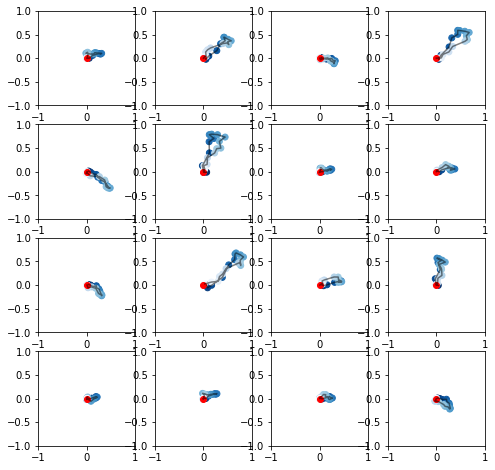

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.39291862079075407, Dr : 0.03179031504052026, Df : 0.01616619580558368


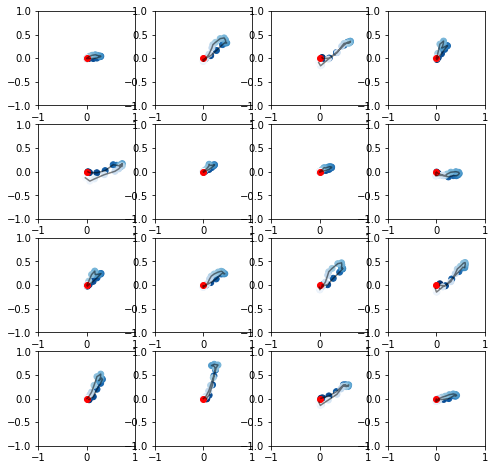

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.2769407629966736, Dr : 0.03472005948424339, Df : 0.03261368349194527


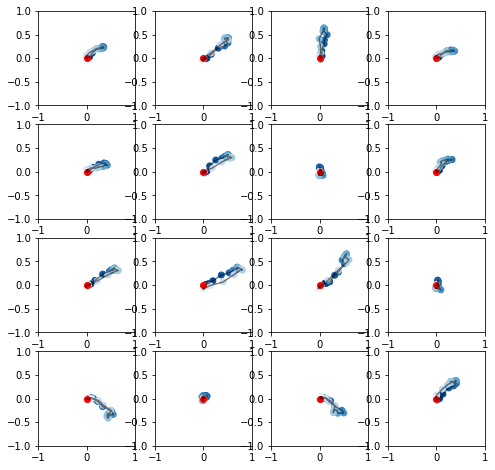

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.3863882507596697, Dr : 0.020710612780281475, Df : 0.022020256146788597


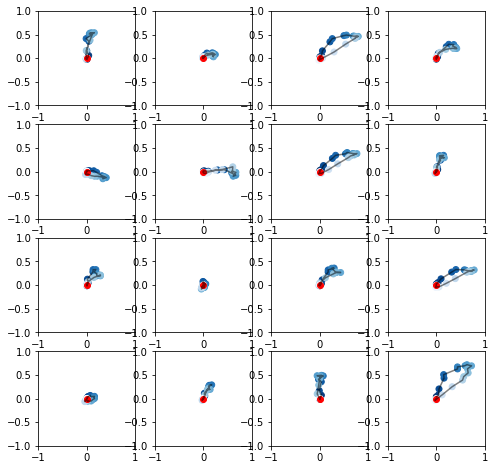

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.4002993788037981, Dr : 0.024810762809855596, Df : 0.020277231399502074


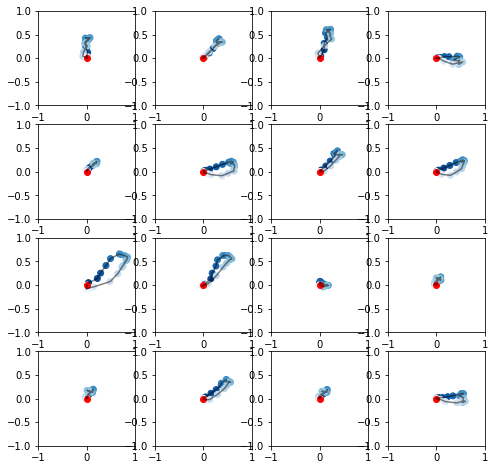

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.26675643239702496, Dr : 0.004010656116796392, Df : 0.024519604231630052


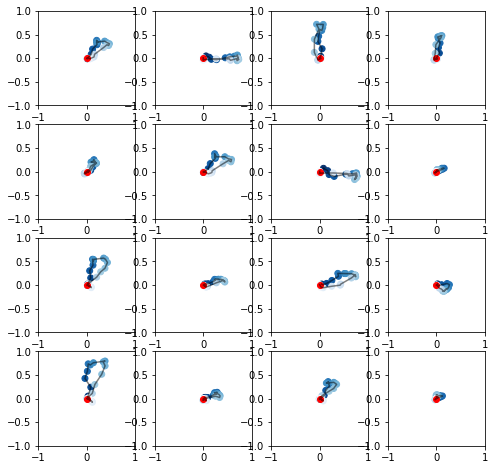

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.3179162059511457, Dr : 0.02982857051704611, Df : 0.006027441604861191


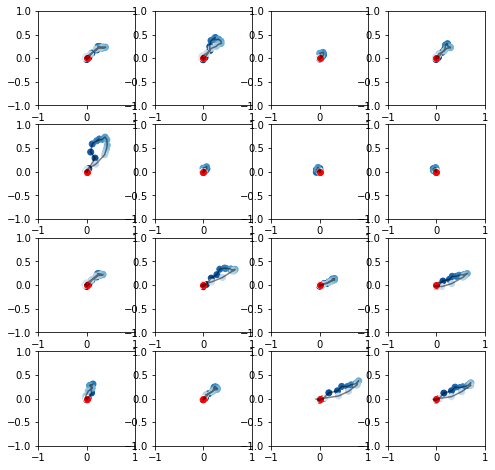

In [41]:
generator = CNNGenerator()
discriminator = CNNDiscriminator()

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

cnn_cnn = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

cnn_cnn.train(nb_epoch, lr, device)

# LSTM - LSTM


Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.08178923385483879, Dr : 0.08204370737075806, Df : 0.11847280178751264


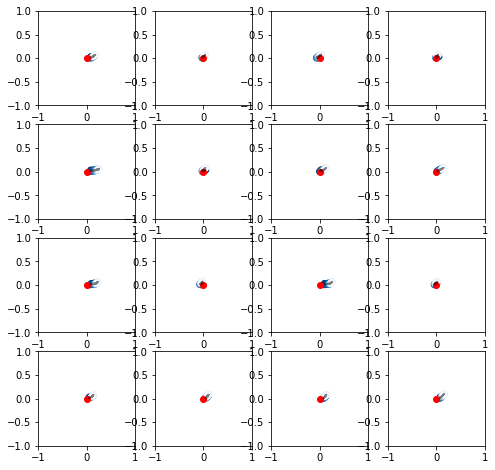

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.0986713639327458, Dr : 0.09852186696869987, Df : 0.09957266705376762


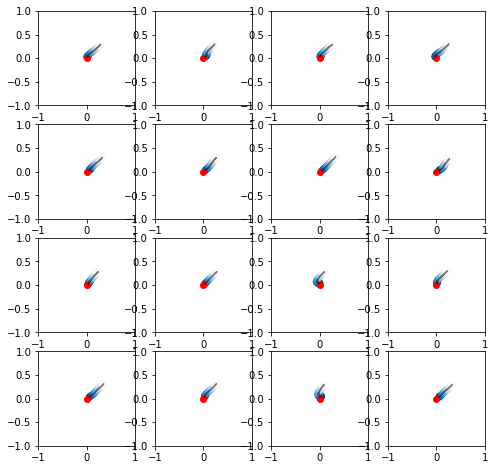

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.09932484797069005, Dr : 0.09955566270010811, Df : 0.0984156004020146


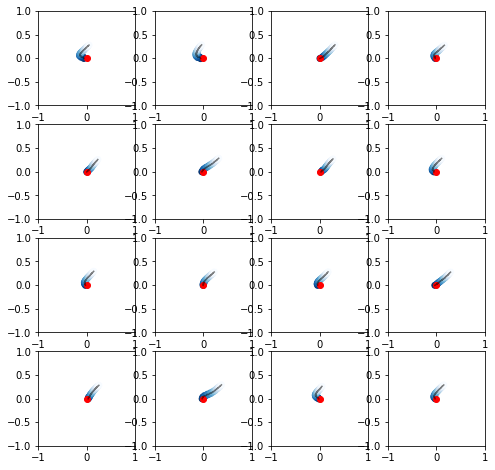

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.0990359399999891, Dr : 0.09917105095727104, Df : 0.09905180335044861


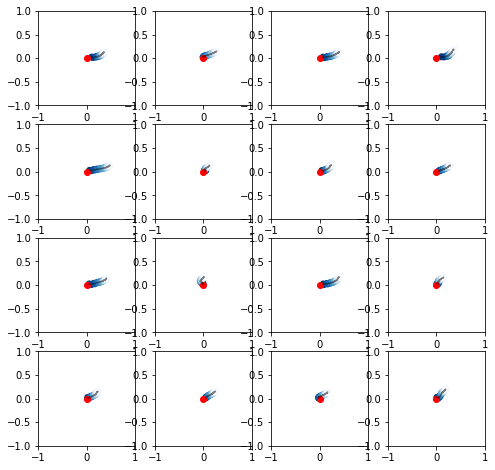

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.09908444966588702, Dr : 0.09905791282653809, Df : 0.09893084423882621


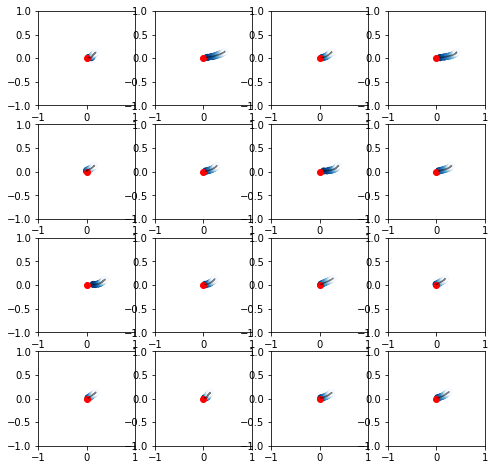

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.0994106147970472, Dr : 0.09919191684041705, Df : 0.09854889767510551


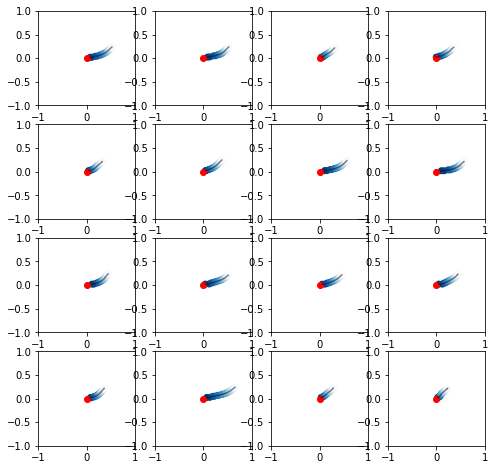

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.098939163344247, Dr : 0.09893461210387093, Df : 0.09906753471919469


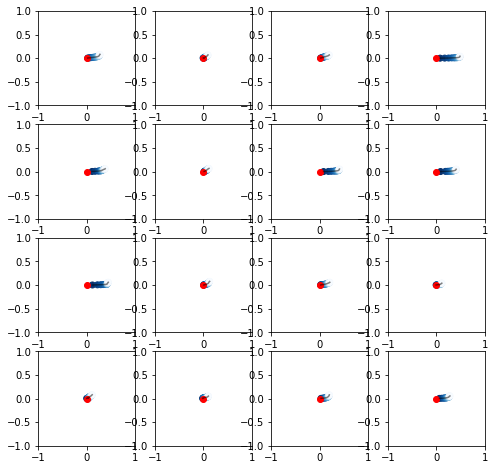

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.09884775962148394, Dr : 0.098952374288014, Df : 0.09909270916666303


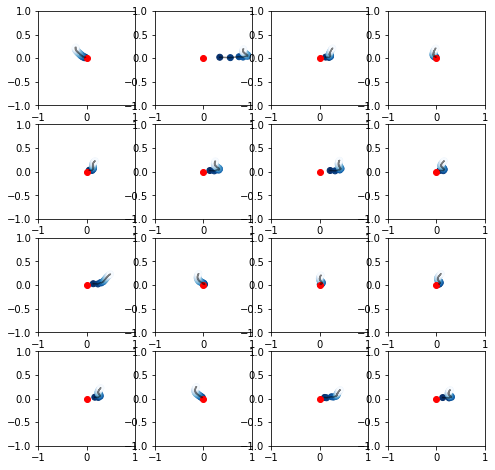

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.0990007391997746, Dr : 0.09887157593454633, Df : 0.09931430646351405


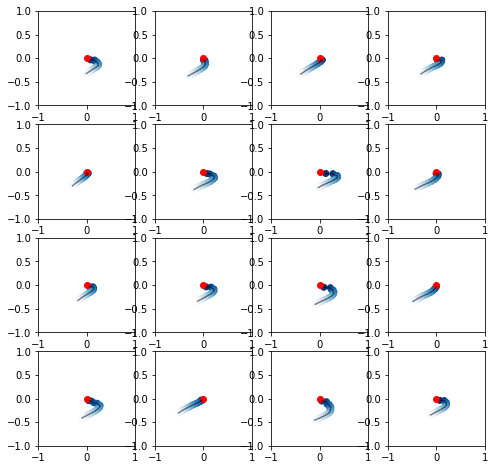

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.0989791750907898, Dr : 0.09908487967082433, Df : 0.09887824313981193


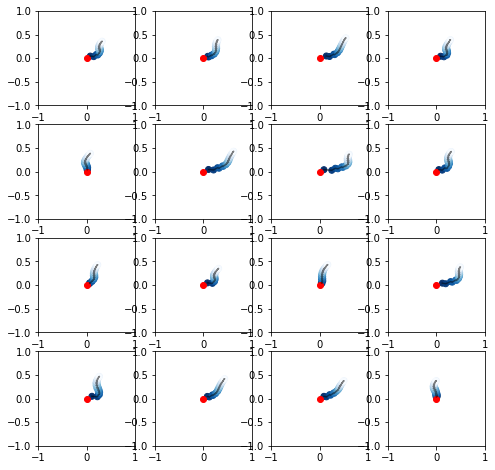

In [42]:
generator = LSTMGenerator().to(device)
discriminator = LSTMDiscriminator().to(device)

# ### WEIGHT INITIALIZATION
# generator.apply(weights_init)
# discriminator.apply(weights_init)

lstm_lstm = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

lstm_lstm.train(nb_epoch, lr, device)

# LSTM - CNN

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.11536178844315666, Dr : 0.09603336879185267, Df : 0.08748457261494227


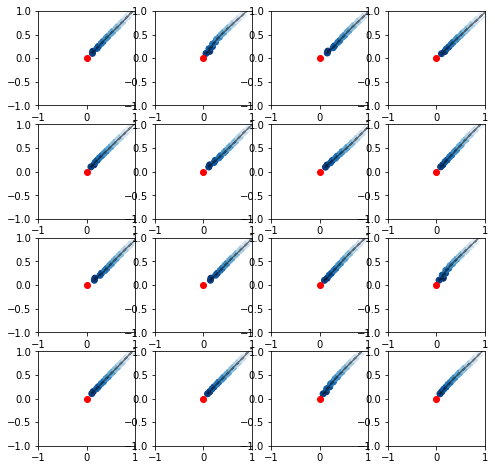

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.6619065829685756, Dr : 0.00115230110740023, Df : 0.0016086543910205364


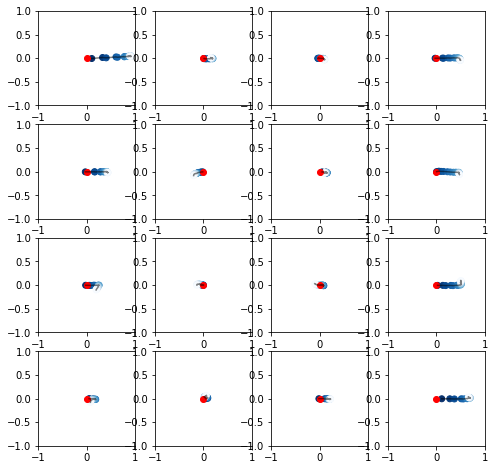

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.9070498943328857, Dr : 0.0002264673904781895, Df : 0.000281833644424166


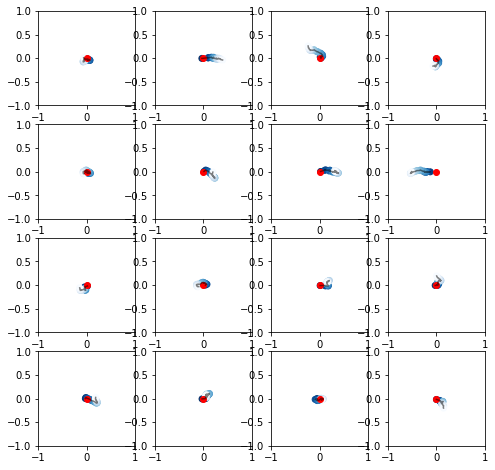

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 1.0544800077165877, Dr : 0.00016035527057413544, Df : 0.00026889895421585867


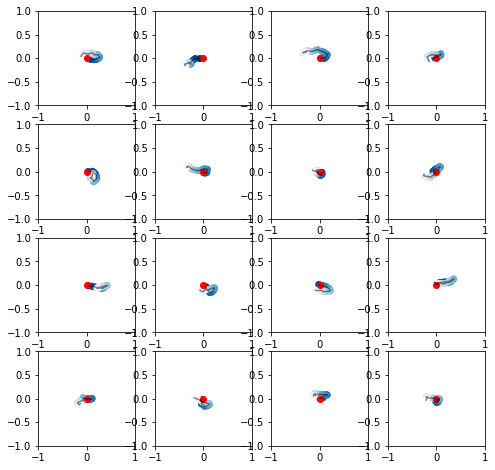

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 1.1375611509595598, Dr : 8.127108490693249e-05, Df : 9.55276981195701e-05


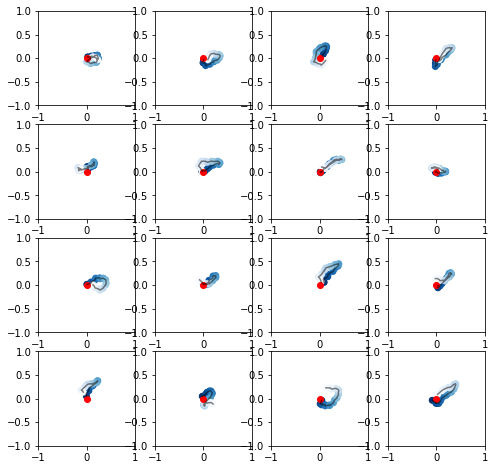

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 1.2212940624782018, Dr : 0.00013051980100239495, Df : 0.0007314329975218113


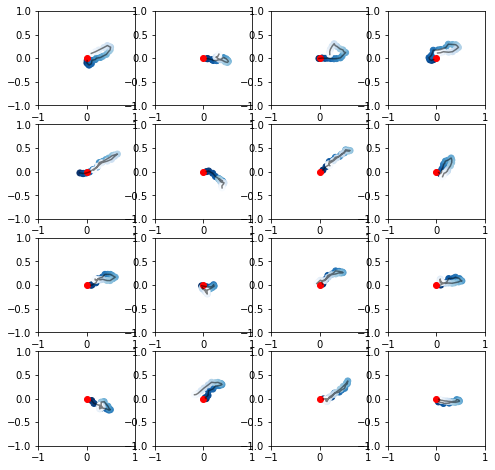

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 1.326395102909633, Dr : 5.808117462687993e-05, Df : 0.00010073942602113155


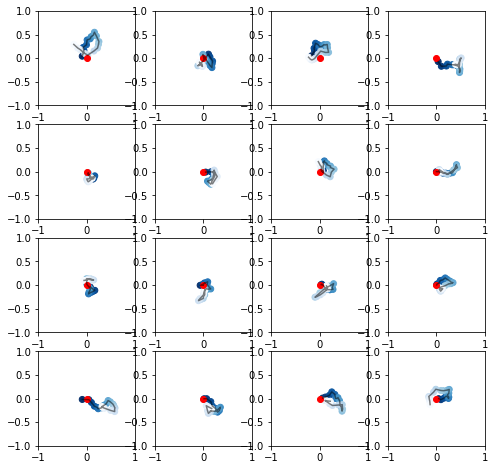

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 1.2683606828962053, Dr : 8.946879409320121e-05, Df : 0.0006531945151177102


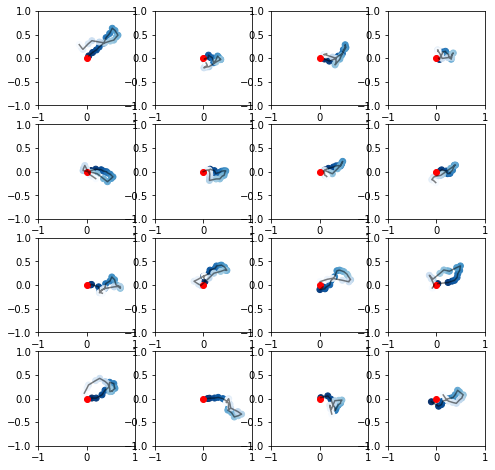

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 1.3611269678388322, Dr : 2.3558262910228223e-05, Df : 1.132660950783507e-05


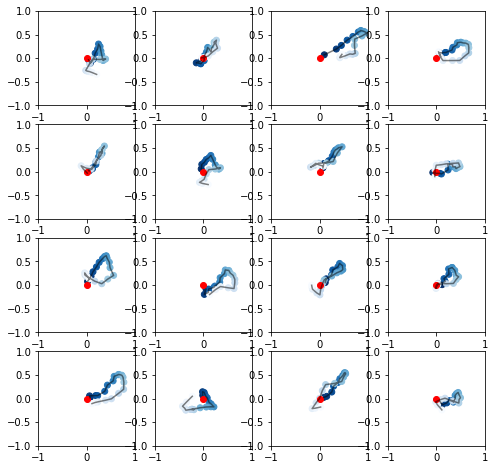

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 1.4111949375697546, Dr : 4.5086404757707245e-05, Df : 9.154349234969622e-06


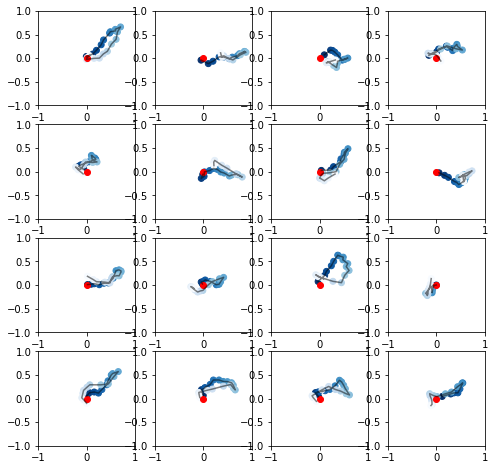

In [43]:
generator = LSTMGenerator().to(device)
discriminator = CNNDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

lstm_cnn = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

lstm_cnn.train(nb_epoch, lr, device)

# CNN - LSTM

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.10466334649494716, Dr : 0.10464487757001605, Df : 0.09365269541740417


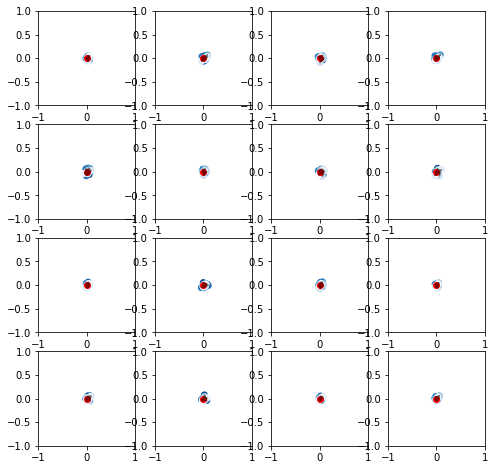

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.09903961845806666, Dr : 0.09905058145523071, Df : 0.09901637264660426


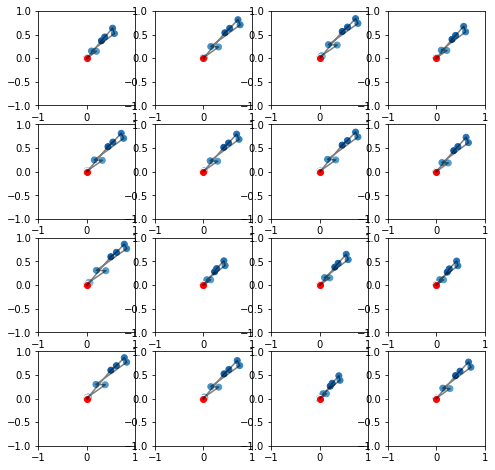

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.09894861493791852, Dr : 0.09898396900721959, Df : 0.09898505892072405


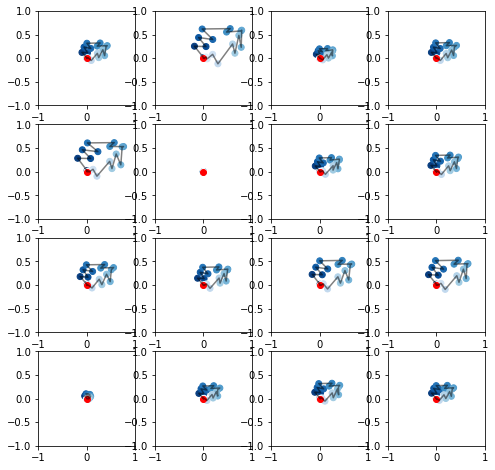

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.09895822831562587, Dr : 0.0989285409450531, Df : 0.09909899745668684


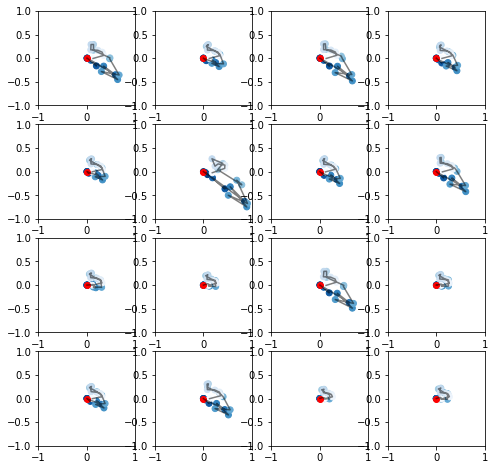

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.09898253423827034, Dr : 0.09901403103555952, Df : 0.09903028607368469


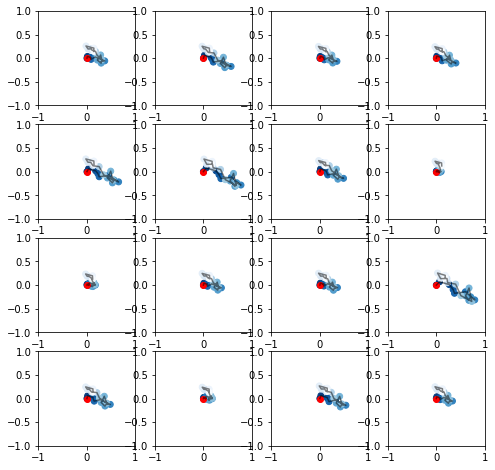

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.09901434183120728, Dr : 0.09901461856705802, Df : 0.0991261899471283


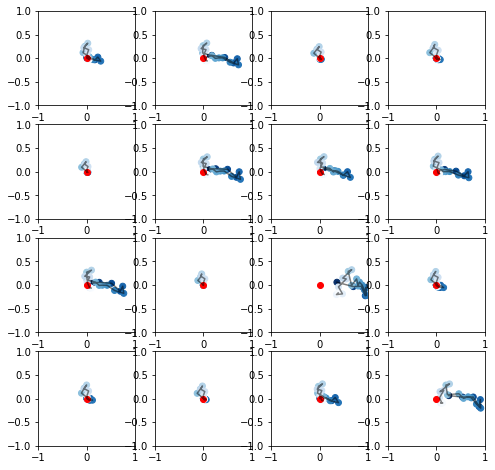

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.0990015012877328, Dr : 0.09905903679983956, Df : 0.09907148991312299


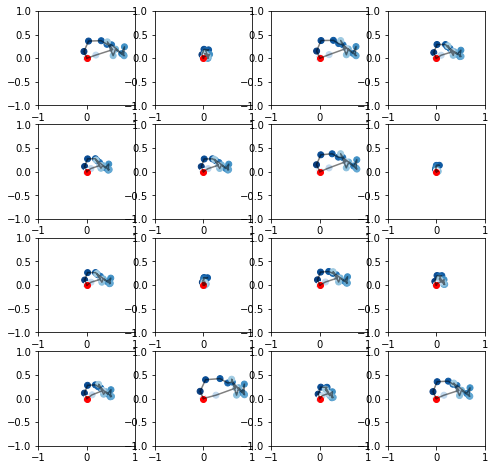

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.09902591790471758, Dr : 0.09899423803601946, Df : 0.09900975227355957


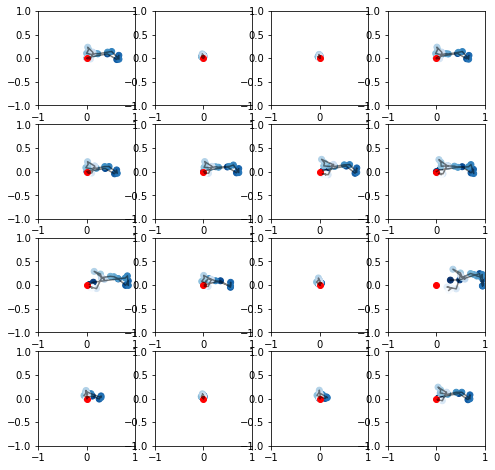

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.0990574700491769, Dr : 0.09899233068738665, Df : 0.09892066461699349


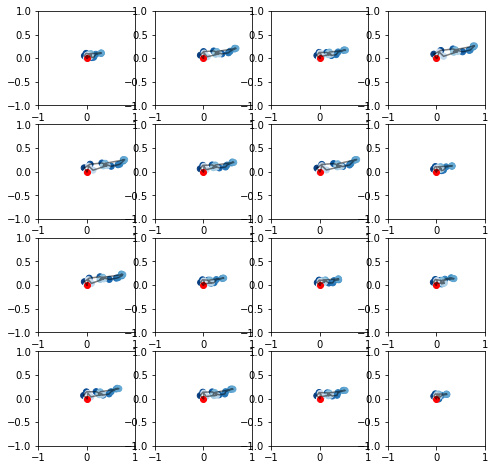

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.099090895482472, Dr : 0.09903727684702192, Df : 0.09903749823570251


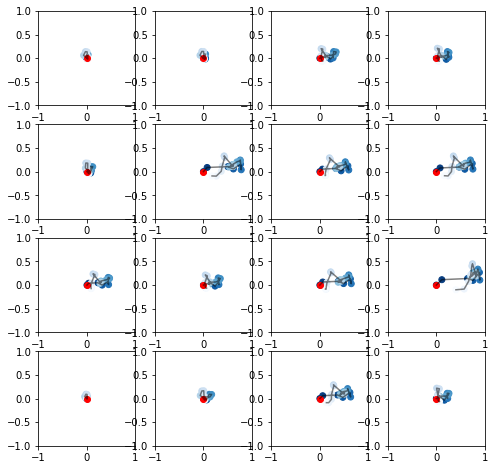

In [44]:
generator = CNNGenerator().to(device)
discriminator = LSTMDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

cnn_lstm = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

cnn_lstm.train(nb_epoch, lr, device)

# RESULTS


Text(0, 0.5, 'Score')

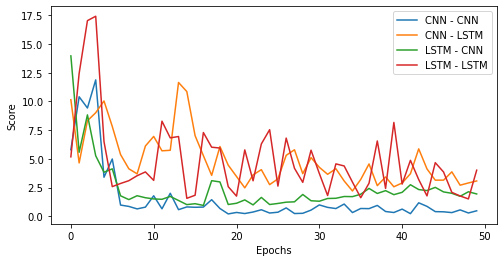

In [45]:
plt.figure(figsize=(8,4))
plt.plot(cnn_cnn.score, label = "CNN - CNN")
plt.plot(cnn_lstm.score, label = "CNN - LSTM")
plt.plot(lstm_cnn.score, label = "LSTM - CNN")
plt.plot(lstm_lstm.score, label = "LSTM - LSTM")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')

In [52]:
score = np.array([cnn_cnn.score, cnn_lstm.score, lstm_cnn.score, lstm_lstm.score])
with open('score_20_steps_SS.npy', 'wb') as f:
    np.save(f, score)

<BarContainer object of 4 artists>

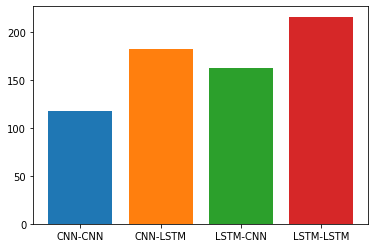

In [53]:
plt.bar(x = ['CNN-CNN', 'CNN-LSTM', 'LSTM-CNN', 'LSTM-LSTM'], 
        height = [cnn_cnn.computation_time, cnn_lstm.computation_time, lstm_cnn.computation_time,lstm_lstm.computation_time],
        color = [dicolour['blue'], dicolour['orange'], dicolour['green'], dicolour['red']])

In [54]:
time = np.array([cnn_cnn.computation_time, cnn_lstm.computation_time, lstm_cnn.computation_time,lstm_lstm.computation_time])
with open('computation_time_20_steps_SS.npy', 'wb') as f:
    np.save(f, time)

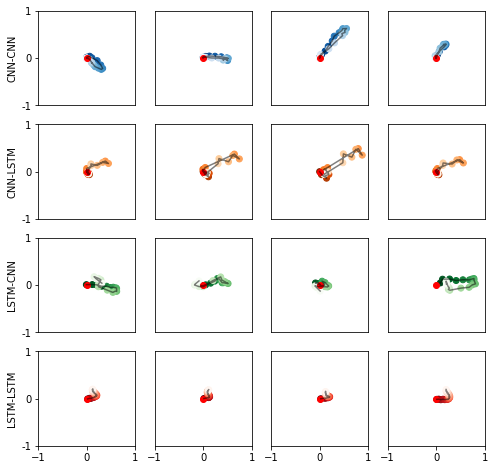

In [55]:
plt.figure(figsize=(8,8))

nb = 4
traj_sim = cnn_cnn.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('CNN-CNN')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)


nb = 4
traj_sim = cnn_lstm.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+4)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('CNN-LSTM')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)

nb = 4
traj_sim = lstm_cnn.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+8)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Greens_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('LSTM-CNN')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)

nb = 4
traj_sim = lstm_lstm.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+12)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Reds_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('LSTM-LSTM')
  ax = plt.gca()
  if i >0:
    ax.axes.yaxis.set_visible(False)

In [56]:
cnn_cnn.save('cnn_cnn_20_steps_SS')
lstm_cnn.save('lstm_cnn_20_steps_SS')
cnn_lstm.save('cnn_lstm_20_steps_SS')
lstm_lstm.save('lstm_lstm_20_steps_SS')